In [1]:
running_in_drive = True
if running_in_drive:
  import os
  os.chdir("/content/drive/MyDrive/GA/capstone/code")

In [2]:
# imports
import os
import pandas as pd
from pandas.io.json import build_table_schema
import numpy as np
import markdown

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

%matplotlib inline

In [3]:
# environment variables
DATA_PATH = '../data'
ORIGINAL_DATA_PATH = f'{DATA_PATH}/original/csv_offshore_leaks'
IMAGE_PATH = '../presentation/images'
MD_PATH = '../presentation/tables'

In [4]:
# helpers

def get_original_file_paths():
  file_names = os.listdir(ORIGINAL_DATA_PATH)
  return {f"{'_'.join(n.split('.')[1:-1])}": f'{ORIGINAL_DATA_PATH}/{n}' for n in file_names} 


def read_original_dataframes():
  paths = get_original_file_paths()
  data_frames = {}
  for name, path in paths.items():
    data_frames[name] = pd.read_csv(path)
  
  return data_frames


def get_schema_table(df):
  schema_dict = build_table_schema(df)
  return pd.DataFrame(schema_dict['fields']).set_index('name')

def get_unique_table(df):
  return pd.DataFrame(df.nunique()).rename(columns={0: '# unique'})




def create_schema_tables(data_frames):
  with open(f'{MD_PATH}/tables.md', 'w') as f:
    for name, df in data_frames.items():
      f.write('\n-----------\n')
      new_name = name.replace('_', ' ').title()
      f.write('### '+ new_name)
      f.write('\n')
      schema_df = get_schema_table(df)
      f.write(schema_df.to_markdown())


def create_schema_tables_without_type(data_frames):
  with open(f'{MD_PATH}/tables_no_type.md', 'w') as f:
    for name, df in data_frames.items():
      f.write('\n\n')
      new_name = name.replace('_', ' ').title()
      f.write('\n')
      schema_df = get_schema_table(df)
      out = schema_df.drop(columns='type')
      out.index.name = new_name
      f.write(out.to_markdown())

def get_table_info(data_frames):
  shapes = {name.replace('_', ' ').title(): df.shape for name, df in data_frames.items()}
  shapes_df = pd.DataFrame(shapes).T.rename(columns={0: '# rows', 1: '# columns'}).sort_values(by='# rows')
  display(shapes_df)

  with open(f'{MD_PATH}/other_info.md', 'w') as f:
    f.write(shapes_df.to_markdown())
    f.write('\n\n')

def get_nunique_columns(data_frames):
  with open(f'{MD_PATH}/nunique_columns.md', 'w') as f:
    for name, df in data_frames.items():
      f.write('\n\n')
      new_name = name.replace('_', ' ').title()
      out = get_unique_table(df)
      out.index.name = new_name
      display(out)
      f.write(out.to_markdown())


In [5]:
paths = get_original_file_paths()
data_frames = read_original_dataframes()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
get_table_info(data_frames)

,# rows,# columns
Nodes Intermediary,9526,8
Nodes Address,57600,8
Nodes Entity,105516,17
Nodes Officer,107190,7
Edges,561393,8


In [7]:
paths

{'edges': '../data/original/csv_offshore_leaks/offshore_leaks.edges.csv',
 'nodes_address': '../data/original/csv_offshore_leaks/offshore_leaks.nodes.address.csv',
 'nodes_entity': '../data/original/csv_offshore_leaks/offshore_leaks.nodes.entity.csv',
 'nodes_intermediary': '../data/original/csv_offshore_leaks/offshore_leaks.nodes.intermediary.csv',
 'nodes_officer': '../data/original/csv_offshore_leaks/offshore_leaks.nodes.officer.csv'}

In [9]:
for name, df in data_frames.items():
  print('\n' + name.upper())
  display(df.head(2))


NODES_ADDRESS


,node_id,name,address,country_codes,countries,sourceID,valid_until,note
0,2004267,NaN,One Bearer Secured Debenture,XXX,Not identified,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
1,67277,NaN,"11 Coomber Road, The Peak, Hong Kong",HKG,Hong Kong,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN



NODES_INTERMEDIARY


,node_id,name,country_codes,countries,status,sourceID,valid_until,note
0,51122,"Peng, Wan-Hsiung",TWN,Taiwan,NaN,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
1,51149,Shin Tae Young,ARE,United Arab Emirates,NaN,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN



NODES_OFFICER


,node_id,name,country_codes,countries,sourceID,valid_until,note
0,51113,Bisbro Investment Company Ltd.,VGB,British Virgin Islands,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
1,51114,Mohamed Mustafa Bin A Mohamed Ismail,MYS,Malaysia,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN



EDGES


,START_ID,TYPE,END_ID,link,start_date,end_date,sourceID,valid_until
0,67028,registered_address,263908,registered address,NaN,NaN,Offshore Leaks,The Offshore Leaks data is current through 2010
1,67243,registered_address,172931,registered address,NaN,NaN,Offshore Leaks,The Offshore Leaks data is current through 2010



NODES_ENTITY


,node_id,name,jurisdiction,jurisdiction_description,country_codes,countries,incorporation_date,inactivation_date,struck_off_date,closed_date,ibcRUC,status,company_type,service_provider,sourceID,valid_until,note
0,67028,ZODIAK LTD,XXX,Undetermined,VGB;CYP,British Virgin Islands;Cyprus,24-AUG-2007,NaN,NaN,NaN,1427813,Dead,Business Company Limited by Shares,Commonwealth Trust Limited,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
1,67243,Zven Ltd.,XXX,Undetermined,XXX;VGB,Not identified;British Virgin Islands,29-JAN-2007,NaN,NaN,NaN,1382756,Dead,Business Company Limited by Shares,Commonwealth Trust Limited,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN


In [10]:
start_ids = set(data_frames['edges']['START_ID'].unique().tolist())
end_ids = set(data_frames['edges']['END_ID'].unique().tolist())
edge_intersection_ids = start_ids.intersection(end_ids)
edge_union_ids = start_ids.union(end_ids)

all_node_ids = []

for name, df in data_frames.items():
  if name!='edges':
    print('\n',name.upper())
    node_ids = set(data_frames[name]['node_id'].unique().tolist())
    all_node_ids.extend(list(node_ids))
    print(f'\tThere are {len(node_ids):,} unique ids')
    
    is_subset = node_ids.issubset(edge_union_ids)
    if is_subset:
      
      print(f'\t{name} is a subset of all edge ids')
    else:
      ids_intersect_all_edges = node_ids.intersection(edge_union_ids)
      print(f'\tThere are {len(ids_intersect_all_edges):,} common ids between {name} and all edge node ids.')

    ids_intersect_start_node = node_ids.intersection(start_ids)
    print(f'\tThere are {len(ids_intersect_start_node):,} common ids between {name} and START ids.')
    ids_intersect_end_node = node_ids.intersection(end_ids)
    print(f'\tThere are {len(ids_intersect_end_node):,} common ids between {name} and END ids.')

print(f'\nThere are {len(set(all_node_ids)):,} node ids')
print(f'There are {len(edge_union_ids):,} START_ID union END ids in edges.')
print(f'\tThere are {len(start_ids):,} unique START_ids')
print(f'\tThere are {len(end_ids):,} unique END ids')
print(f'\tThere are {len(edge_intersection_ids):,} START_ID intersection END ids')



 NODES_ADDRESS
	There are 57,600 unique ids
	nodes_address is a subset of all edge ids
	There are 0 common ids between nodes_address and START ids.
	There are 57,600 common ids between nodes_address and END ids.

 NODES_INTERMEDIARY
	There are 9,526 unique ids
	nodes_intermediary is a subset of all edge ids
	There are 9,526 common ids between nodes_intermediary and START ids.
	There are 39 common ids between nodes_intermediary and END ids.

 NODES_OFFICER
	There are 107,190 unique ids
	nodes_officer is a subset of all edge ids
	There are 107,190 common ids between nodes_officer and START ids.
	There are 1,163 common ids between nodes_officer and END ids.

 NODES_ENTITY
	There are 105,516 unique ids
	There are 105,492 common ids between nodes_entity and all edge node ids.
	There are 85,942 common ids between nodes_entity and START ids.
	There are 105,488 common ids between nodes_entity and END ids.

There are 278,693 node ids
There are 278,669 START_ID union END ids in edges.
	There ar

In [11]:
edges = data_frames['edges'].copy()

In [12]:
edges.head()

,START_ID,TYPE,END_ID,link,start_date,end_date,sourceID,valid_until
0,67028,registered_address,263908,registered address,NaN,NaN,Offshore Leaks,The Offshore Leaks data is current through 2010
1,67243,registered_address,172931,registered address,NaN,NaN,Offshore Leaks,The Offshore Leaks data is current through 2010
2,67258,registered_address,264788,registered address,NaN,NaN,Offshore Leaks,The Offshore Leaks data is current through 2010
3,67266,registered_address,263908,registered address,NaN,NaN,Offshore Leaks,The Offshore Leaks data is current through 2010
4,108050,registered_address,285718,registered address,NaN,NaN,Offshore Leaks,The Offshore Leaks data is current through 2010


In [13]:
edges.head(1)

,START_ID,TYPE,END_ID,link,start_date,end_date,sourceID,valid_until
0,67028,registered_address,263908,registered address,NaN,NaN,Offshore Leaks,The Offshore Leaks data is current through 2010


In [14]:
edges.nunique()

START_ID       201519
TYPE                4
END_ID         164251
link               53
start_date       6240
end_date         4342
sourceID            1
valid_until         1
dtype: int64

In [15]:
data_frames['nodes_address']

,node_id,name,address,country_codes,countries,sourceID,valid_until,note
0,2004267,NaN,One Bearer Secured Debenture,XXX,Not identified,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
1,67277,NaN,"11 Coomber Road, The Peak, Hong Kong",HKG,Hong Kong,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
2,67346,NaN,"4 Irish Place 2nd Floor, Gibraltar.",GIB,Gibraltar,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
3,67278,NaN,"11A, Branksome 3 Tregunter Path Mid-Levels Hon...",HKG,Hong Kong,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
4,67282,NaN,14 Lysander Road West Mailing Kent ME19 4TT,GBR,United Kingdom,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
...,...,...,...,...,...,...,...,...
57595,67598,NaN,"10B/15 Shun Ning Road, Kowloon, Hong Kong",HKG,Hong Kong,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
57596,67476,NaN,"ul.Rudnevoy 19A,Berdyansk, Ukraine.",UKR,Ukraine,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
57597,67530,NaN,10 Hill Close Peckleton Leicestershire UNITED ...,GBR,United Kingdom,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN
57598,67532,NaN,"10 Lichfield Road, London, NW2 2RE",GBR,United Kingdom,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN


In [71]:
columns = ['node_id', 'country_codes', 'countries']
DF = []
for name, df in data_frames.items():
  if name not in ['edges']:
    sub = df[columns].copy()
    sub['table']=name
    DF.append(sub)

out = pd.concat(DF)
print(out.shape)
out.drop_duplicates(inplace=True)
print(out.shape)

(279832, 4)
(279832, 4)


In [72]:
out.head()

,node_id,country_codes,countries,table
0,2004267,XXX,Not identified,nodes_address
1,67277,HKG,Hong Kong,nodes_address
2,67346,GIB,Gibraltar,nodes_address
3,67278,HKG,Hong Kong,nodes_address
4,67282,GBR,United Kingdom,nodes_address


In [106]:
def plot_country_count(plot_all=False, title='', node_frames=[]):
  

  if plot_all:
    title = 'All Tables'
    node_frames = ['nodes_address', 'nodes_intermediary', 'nodes_officer', 'nodes_entity']
  
  if title=='':
    title = ' & '.join(node_frames).replace('_', ' ').upper().replace("NODES", '')
    
  columns = ['node_id', 'country_codes', 'countries']
  DF = []
  for name, df in data_frames.items():
    if name in node_frames:
      sub = df[columns].copy()
      sub['table']=name
      DF.append(sub)
  out = pd.concat(DF)
  out.drop_duplicates(inplace=True)
  country_count = pd.DataFrame(out.groupby('countries')['node_id'].count().sort_values(ascending=False))
  country_count.columns = ['Count']
  country_count.index.name = 'Country'
  country_count.reset_index(inplace=True)
  #display(country_count.head())
  n_show =25
  plt.figure(figsize=(15, 10))
  g = sns.barplot(data=country_count.head(n_show), y='Country', x='Count',
                  edgecolor=sns.color_palette("colorblind", n_show),
                facecolor=(0, 0, 0, 0));
  g.set_title(title);
  sns.despine(top=True);
  g.set_ylabel('');
  g.tick_params(left=False, right=False, bottom=False);

  plt.savefig(f'{IMAGE_PATH}/top_{n_show}_countries_{"_".join(node_frames).replace("nodes", "")}.png', 
                      bbox_inches='tight', dpi=300)

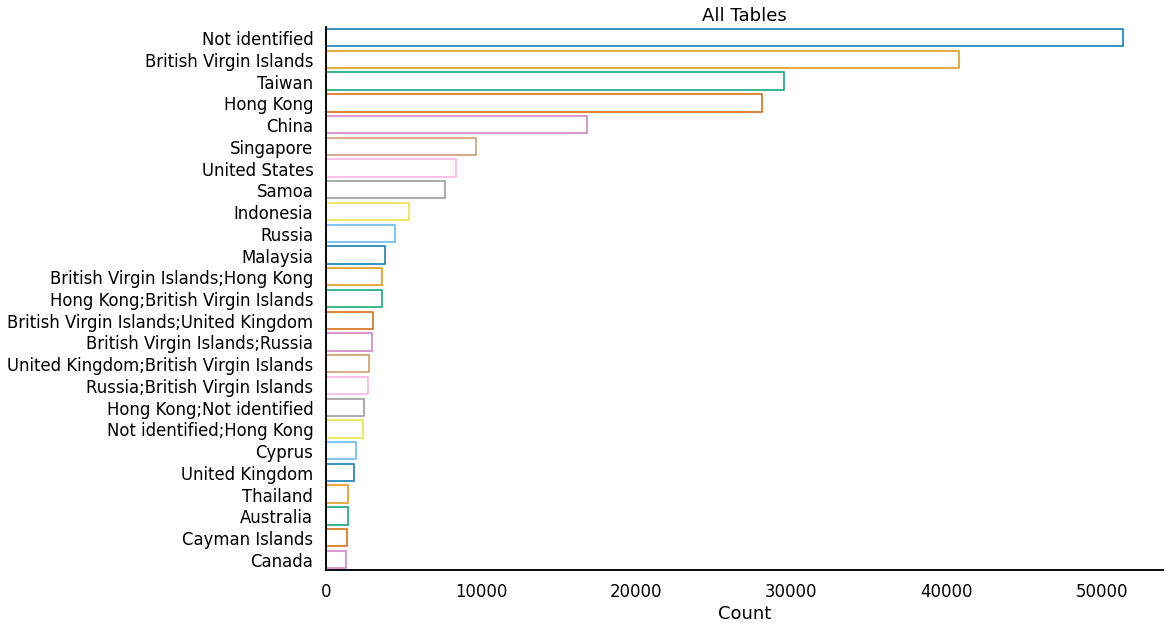

In [107]:
plot_country_count(plot_all=True)

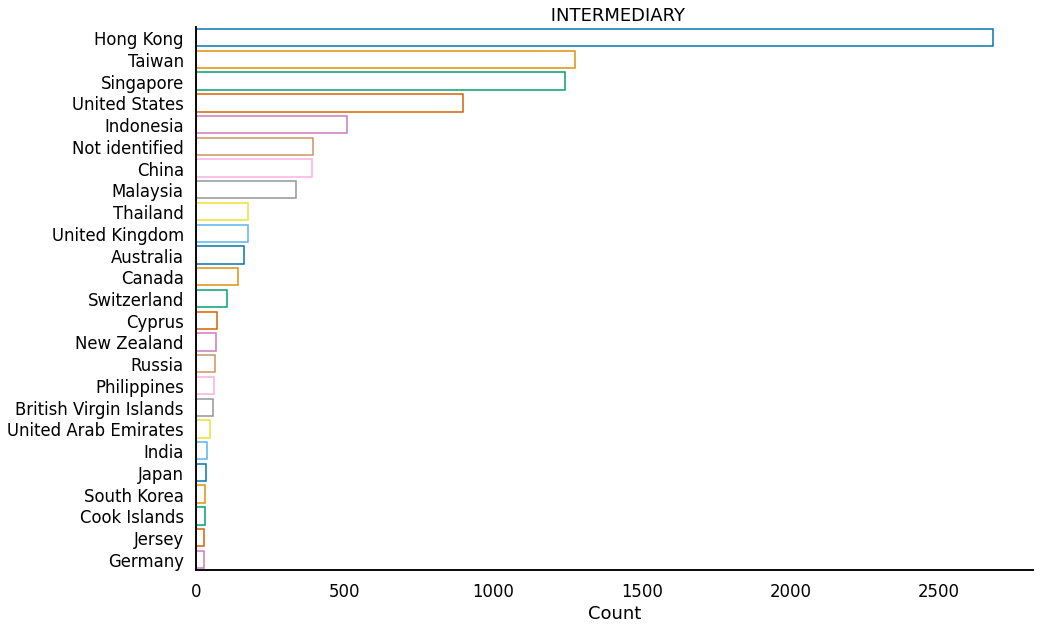

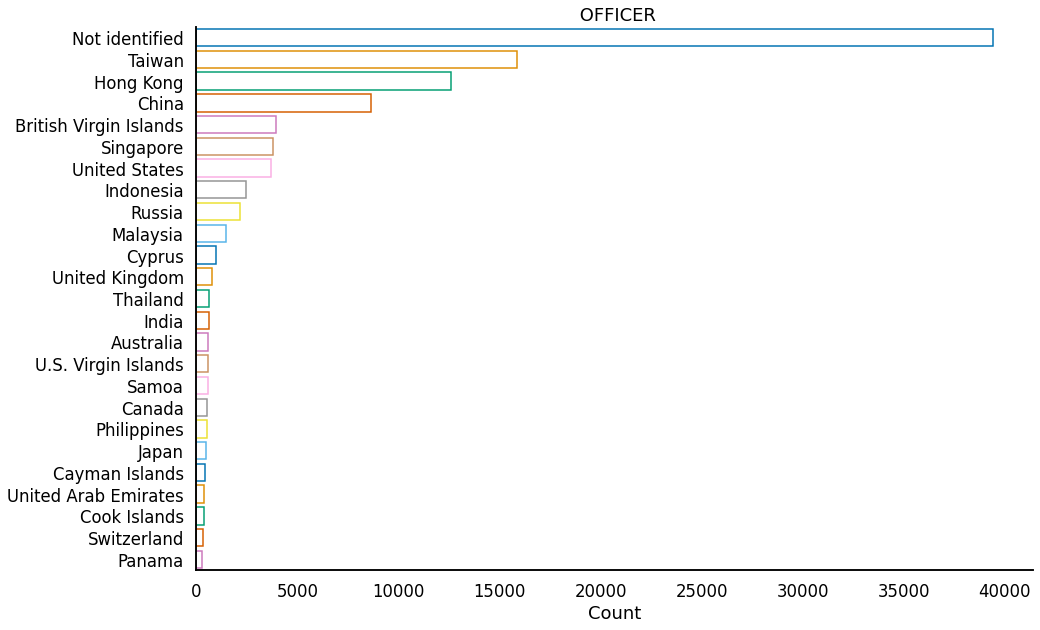

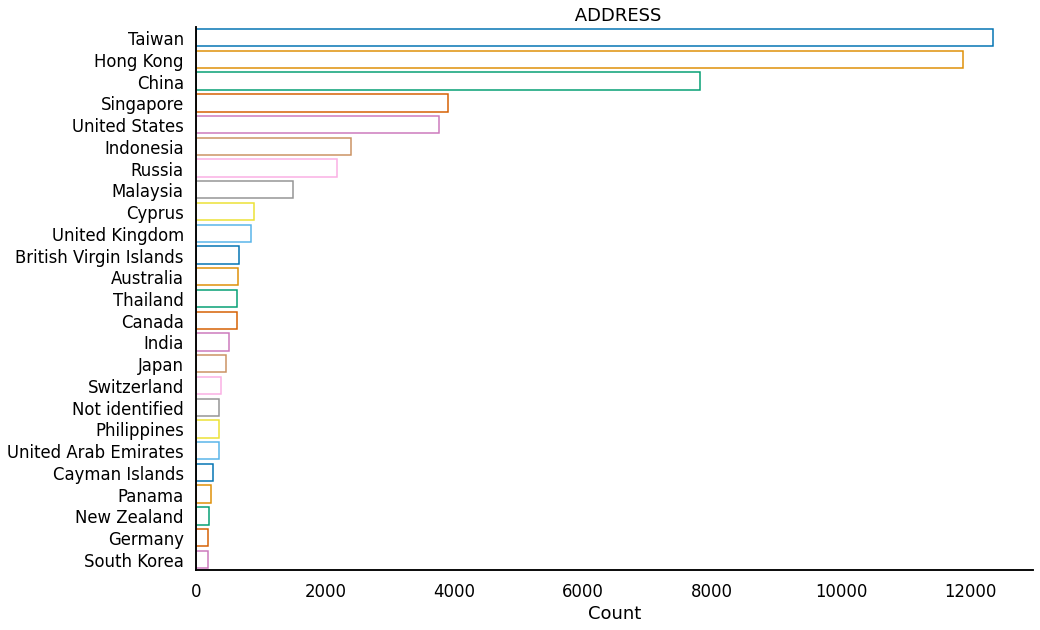

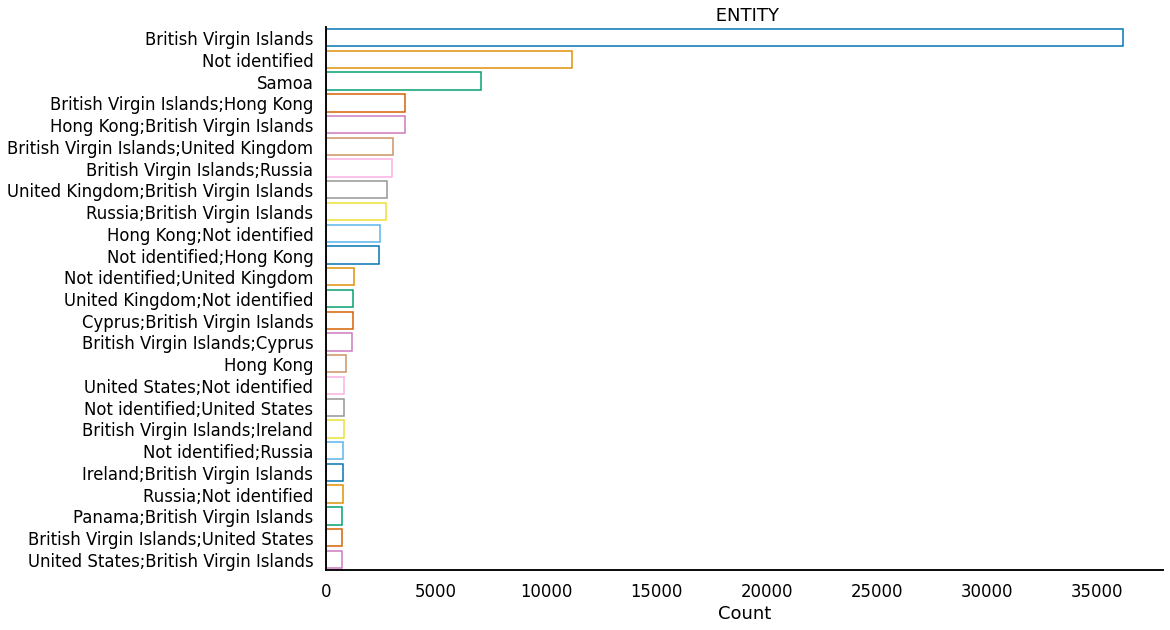

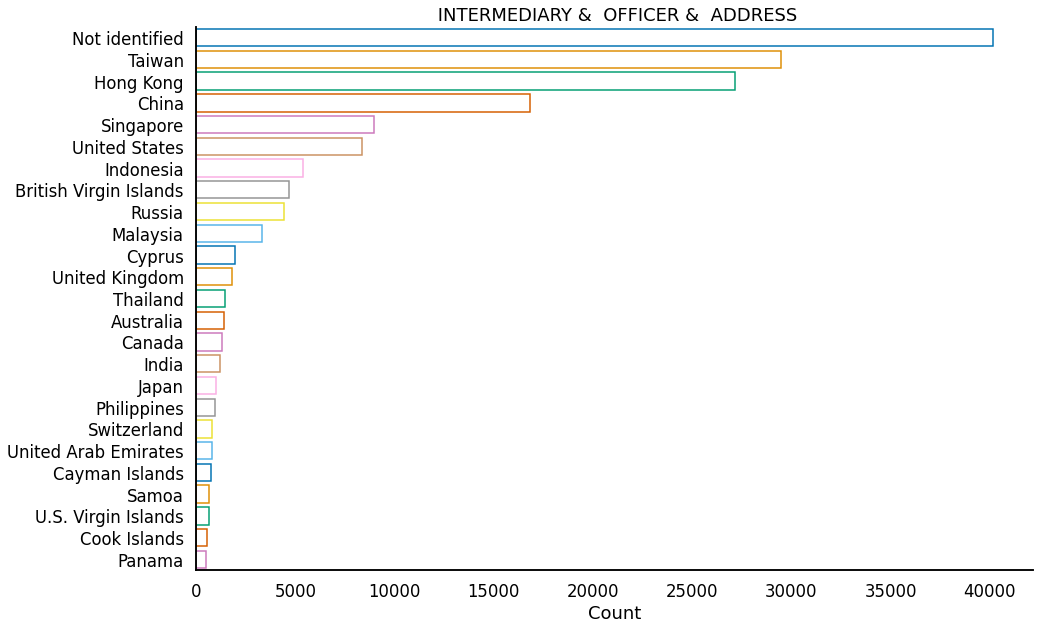

In [108]:
for tab in ['nodes_intermediary', 'nodes_officer', 'nodes_address', 'nodes_entity']:
  plot_country_count(plot_all=False, title='', node_frames=[tab])

plot_country_count(plot_all=False, title='', node_frames=['nodes_intermediary', 'nodes_officer', 'nodes_address'])

In [17]:
start_end_edges = edges[['START_ID', 'END_ID']].values.tolist()

In [18]:
!pip install networkx

```
draw_networkx_edges(G, pos, edgelist=None, width=1.0, edge_color='k', style='solid', alpha=1.0, edge_cmap=None, edge_vmin=None, edge_vmax=None, ax=None, arrows=True, label=None, **kwds)```


In [28]:
len(start_end_edges)

561393

In [34]:
import networkx as nx

G = nx.Graph()
to_draw = start_end_edges[:20000]
G.add_edges_from(to_draw)
nx.draw_networkx(G,with_labels=False,alpha=.2, width=.1)
plt.box(False)
plt.savefig(f'{IMAGE_PATH}/first_graph_{len(to_draw)}.png', dpi=300, bbox_inches='tight')

KeyboardInterrupt: ignored